<a href="https://colab.research.google.com/github/borre103/forecast-transformer/blob/main/Series_Temporales_IBorrego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 58.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
#Importación de librerías

import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Configuración del estilo de los gráficos para mejorar visualización
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [ ]:
# Definimos la métrica MAPE (Mean Absolute Percentage Error), útil para evaluar errores relativos en modelos de predicción.
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE)

    Args:
        y_true: Actual values
        y_pred: Predicted values

    Returns:
        MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Se ignoran los valores donde y_true = 0 para evitar divisiones por cero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Database Transformers.csv to Database Transformers.csv


# **Carga y Limpieza inicial de los datos**

Cargué una base de datos preprocesada con información mensual desde Octubre 2019 hasta Junio 2025 (no tenía información más antigua de importaciones), que incluye las ventas (en unidades) e importaciones de dos líneas de negocio: Ostomy Care (OC) e Intermittent Catheters (IC). También cuenta con la variable Lead_days, que representa el tiempo entre la importación y la disponibilidad de los productos en el país. Empezaré haciendo un forecast de las ventas de OC, y luego lo haré con IC

En esta primera etapa, realicé un proceso de limpieza y validación de los datos. No conté con información histórica completa de Lead_days para todos los meses del dataset. Por eso, imputé los valores faltantes utilizando una estrategia que:


*   Calcula el promedio observado de Lead_days (60.82 días)
*   Genera valores aleatorios dentro del rango observado (mínimo: 41, máximo 97 días)
*   Ajusta estos valores simulados para que el promedio total de la columna se mantenga lo más cercano posible a 60.82



In [ ]:
# Leemos el archivo con separador explícito
df = pd.read_csv("Database Transformers.csv", sep=";", encoding="utf-8", dtype={"Fecha":str})


In [ ]:
# Eliminamos espacios de los nombres de columnas
df.columns = df.columns.str.strip()

# Columnas numéricas que deben limpiarse
cols_to_clean = ['Ventas_OC', 'Ventas_IC', 'Importaciones_OC', 'Importaciones_IC']

for col in cols_to_clean:
    df[col] = df[col].astype(str)                         # Convertimos a string
    df[col] = df[col].str.replace(",", "", regex=False)   # Sacamos comas como separador de miles
    df[col] = df[col].str.strip().replace(['-', '', ' '], '0')  #Convertimos valores vacíos o inválidos en "0"
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)       # Volvemos a int (soporta NaN)


df["Lead_days"] = df["Lead_days"].astype(float)




In [ ]:
#El file me traia dos filas sin informacion con fecha N/A, Asi que voy a eliminarlas.
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%m/%d/%Y')


In [ ]:
#Hago una copia de las ventas originales en la columna Ventas_OC_raw antes de escalar, el cual va a ser clave para desescalar las predicciones
df['Ventas_OC_raw'] = df['Ventas_OC']

In [ ]:
#Identifico cuántos valores faltan
missing_count = df['Lead_days'].isna().sum()
print(f"Valores faltantes de Lead_days: {missing_count}")

# Valores conocidos
lead_days_existentes = df['Lead_days'].dropna().values
target_mean = 60.82

# Paso 3: calcular suma total deseada
total_values = len(df)
suma_objetivo = total_values * target_mean
suma_existente = lead_days_existentes.sum()
suma_necesaria = suma_objetivo - suma_existente

# Generó simulados dentro del rango 41-97 (min-max) que sumen lo necesario
np.random.seed(42)
# Inicializo con valores aleatorios
lead_days_simulados = np.random.randint(41, 98, size=missing_count)

# Ajusto proporcionalmente para alcanzar la suma necesaria
factor = suma_necesaria / lead_days_simulados.sum()
lead_days_simulados = np.clip((lead_days_simulados * factor).round(), 41, 97).astype(int)

# insertar
df.loc[df['Lead_days'].isna(), 'Lead_days'] = lead_days_simulados

# Validación
print(f"Nuevo promedio de Lead_days: {df['Lead_days'].mean():.2f}")
print(f"Min: {df['Lead_days'].min()}, Max: {df['Lead_days'].max()}")


Valores faltantes de Lead_days: 24
Nuevo promedio de Lead_days: 60.91
Min: 41.0, Max: 97.0


In [ ]:
df = df.replace({pd.NA: np.nan})
df = df.dropna()
print(df.columns)

Index(['Fecha', 'Ventas_OC', 'Ventas_IC', 'Importaciones_OC',
       'Importaciones_IC', 'Lead_days', 'Ventas_OC_raw'],
      dtype='object')


MinMaxScaler transforma los valores de una columna numérica para que estén en un rango entre 0 y 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_ventas_oc = MinMaxScaler()
#df['Ventas_OC_raw'] = df['Ventas_OC']  # Guardar original para comparar resultados de predicción vs realidad
df['Ventas_OC'] = scaler_ventas_oc.fit_transform(df[['Ventas_OC']])


**Preparación de las features**

Creé un lag de 2 meses en importaciones y en el lead time, considerando que el tiempo promedio desde la importación hasta la venta es de aproximadamente 2 meses.

También calculé un rolling mean de 3 meses para las ventas de OC para reducir la volatilidad.

Como los lags y rolling requieren datos anteriores, las primeras filas generan NaN, por lo tanto fueron eliminadas.

Luego, preparo el target: entreno un segundo MinMaxScaler solo en la columna Ventas_OC_raw para poder desescarlarlo tras la predicción


In [ ]:
# Crear regresores con lag y rolling para OC e IC
# Usamos lead_days promedio como referencia (~2 meses)

# Lags (por lead time estimado)
df['Importaciones_OC_lag2'] = df['Importaciones_OC'].shift(2)
df['Importaciones_IC_lag2'] = df['Importaciones_IC'].shift(2)
df['Lead_days_lag2'] = df['Lead_days'].shift(2)  # mismo para OC e IC

# Rolling mean de ventas (estabiliza la serie)
df['Ventas_OC_roll3'] = df['Ventas_OC'].rolling(window=3).mean()
df['Ventas_IC_roll3'] = df['Ventas_IC'].rolling(window=3).mean()



In [ ]:
# Eliminamos las primeras filas que quedaron con NaNs por los lags/rollings
df = df.dropna().reset_index(drop=True)


In [ ]:
features_to_scale = [
    'Importaciones_OC', 'Lead_days',
    'Importaciones_OC_lag2', 'Lead_days_lag2', 'Ventas_OC_roll3'
]

scaler_features_oc = MinMaxScaler()
df[features_to_scale] = scaler_features_oc.fit_transform(df[features_to_scale])

scaler_target = MinMaxScaler()
scaler_target.fit(df[['Ventas_OC_raw']])   # con la columna original de ventas


MinMaxScaler()

Definí las features y el objetivo. El modelo observará 12 meses para atrás e intentará predecir 3 meses en el futuro, donde la variable objetivo son las Ventas_OC.


Creé un dataset personalizado (ForecastDataset) que genera muestras para el entrenamiento del modelo:


*   x_demand: el target pasado (Histórico de ventas_oc de 12 meses)
*   x_regressors: variables exógenas (Importaciones, lead days)
*   y_demand: El objetivo (ventas de Julio a septiembre 2025)






In [ ]:
# Creo la columna target ya normalizada para el modelo
df['target'] = scaler_target.transform(df[['Ventas_OC_raw']])
#print(df[['Fecha', 'Ventas_OC_raw', 'target']].tail(10))


Ahora genero la columna target, que contiene las ventas originales escaladas entre 0 y 1, lista para entrenar el modelo. A continuación, renombro las columnas de lag para usar nombres más concisos en los features finales, y defino los parámetros de ventana input_len, forecast_horizon junto con la lista de variables de entradainput_features_OC.

In [ ]:
# Rehacer input_features
input_features_OC = [
    'importaciones',
    'lead_days',
    'Ventas_OC_roll3'
]

target_col = 'target'
input_len = 12
forecast_horizon = 3

df = df.rename(columns={
    'Importaciones_OC_lag2': 'importaciones',
    'Lead_days_lag2': 'lead_days'
})




In [ ]:
class ForecastDataset(Dataset):
    def __init__(self, df, input_window, forecast_window, input_features, target_col):
        self.df = df
        self.input_window = input_window
        self.forecast_window = forecast_window
        self.total_window = input_window + forecast_window
        self.input_features = input_features
        self.target_col = target_col

    def __len__(self):
        return len(self.df) - self.total_window + 1

    def __getitem__(self, idx):
        # Input: target pasado (x_demand)
        x_demand = torch.tensor(
            self.df[self.target_col].iloc[idx : idx + self.input_window].values,
            dtype=torch.float32
        ).unsqueeze(-1)

        # Input: features exógenas (x_regressors)
        x_regressors = torch.tensor(
            self.df[self.input_features].iloc[idx : idx + self.input_window].values,
            dtype=torch.float32
        )

        # Output: target futuro (y_demand)
        y_demand = torch.tensor(
            self.df[self.target_col].iloc[idx + self.input_window : idx + self.total_window].values,
            dtype=torch.float32
        ).unsqueeze(-1)

        return {
            'x_demand': x_demand,
            'x_regressors': x_regressors,
            'y_demand': y_demand
        }


In [ ]:
input_len = 12
forecast_horizon = 3

target_col = 'target'

dataset = ForecastDataset(
    df=df,
    input_window=input_len,
    forecast_window=forecast_horizon,
    input_features=input_features_OC,
    target_col='target'
)

In [ ]:
sample_item = dataset[0]
x_demand_sample = sample_item['x_demand'].squeeze().numpy()


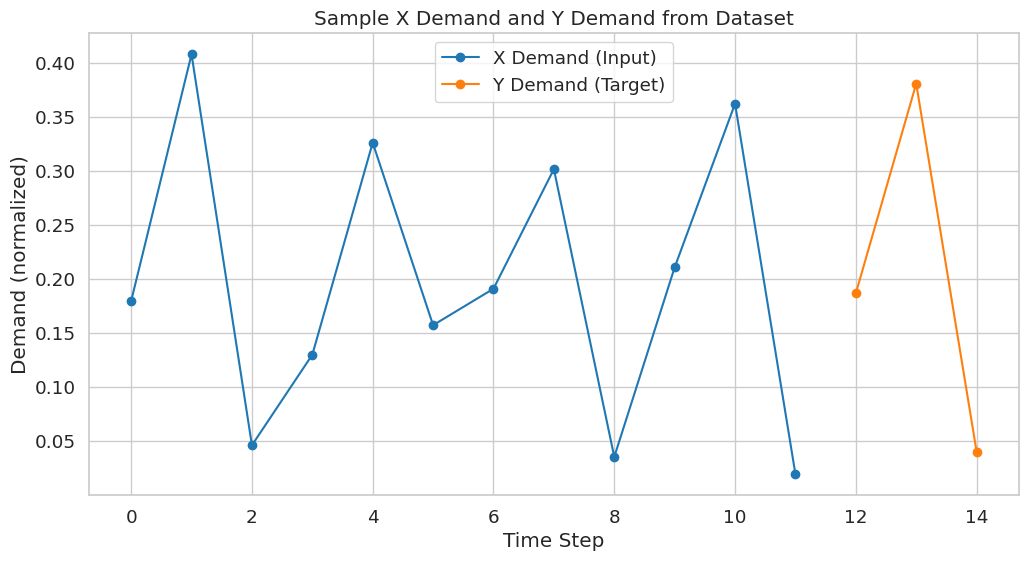

In [ ]:
sample_item = dataset[0]

x_demand_sample = sample_item['x_demand'].squeeze().numpy()
y_demand_sample = sample_item['y_demand'].squeeze().numpy()

x_indices = np.arange(len(x_demand_sample))
y_indices = np.arange(len(x_demand_sample), len(x_demand_sample) + len(y_demand_sample))

plt.figure(figsize=(12, 6))
plt.plot(x_indices, x_demand_sample, label='X Demand (Input)', marker='o', linestyle='-')
plt.plot(y_indices, y_demand_sample, label='Y Demand (Target)', marker='o', linestyle='-')
plt.title('Sample X Demand and Y Demand from Dataset')
plt.xlabel('Time Step')
plt.ylabel('Demand (normalized)')
plt.legend()
plt.grid(True)
plt.show()

**Este bloque divide el dataset total en 3 subconjuntos:**


*  80% para entrenamiento
*  10% para validación
*  10% para testeo

Luego se crean Subset y DataLoader para cada uno, que sirven para alimentar el modelo por lotes

In [ ]:
from torch.utils.data import Subset, DataLoader

# División 80% / 10% / 10%
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, total_size))

# Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
class EnergyTimeSeriesDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=32):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

        sample = train_dataset[0]
        self.input_dim = sample['x_demand'].shape[1]
        self.output_dim = sample['y_demand'].shape[1]
        self.forecast_length = sample['y_demand'].shape[0]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def get_input_dim(self):
        sample = self.train_dataset[0]
        return sample['x_demand'].shape[1] + sample['x_regressors'].shape[1]

    def get_output_dim(self):
        return self.output_dim

    def get_forecast_length(self):
        return self.forecast_length


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


# Modelo transformer para series temporales usando Pytorch Lightning

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class TransformerForecastingModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, forecast_length, d_model=64, nhead=4, num_encoder_layers=2, dim_feedforward=128, dropout=0.1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.decoder = nn.Linear(d_model, output_dim)
        self.lr = lr

    def forward(self, x_demand, x_regressors):
        # Concatenar demanda + regresores si hay regresores
        if x_regressors is not None:
            x = torch.cat([x_demand, x_regressors], dim=-1)
        else:
            x = x_demand

        # Pasar por input projection
        x = self.input_projection(x)
        x = self.positional_encoding(x)

        x = self.transformer_encoder(x)
        output = self.decoder(x[:, -self.hparams.forecast_length:, :])
        return output

    def training_step(self, batch, batch_idx):
        y_hat = self(batch['x_demand'], batch['x_regressors'])
        loss = nn.functional.mse_loss(y_hat, batch['y_demand'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch['x_demand'], batch['x_regressors'])
        loss = nn.functional.mse_loss(y_hat, batch['y_demand'])
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        y_hat = self(batch['x_demand'], batch['x_regressors'])
        loss = nn.functional.mse_loss(y_hat, batch['y_demand'])
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)



In [ ]:
import torch.nn.functional as F
import pytorch_lightning as pl


class BaseForecaster(pl.LightningModule):
    """Base class for forecasting models with common functionality."""

    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate

    def common_step(self, batch):
        """Common operations for training, validation, and test steps."""
        x = batch['x_demand']
        x_regressors = batch.get('x_regressors', None)
        y = batch['y_demand']

        y_hat = self(x, x_regressors)
        loss = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        # Calculate MAPE
        y_np = y.cpu().numpy()
        y_hat_np = y_hat.detach().cpu().numpy()
        # Avoid division by zero
        mask = y_np != 0
        mape = np.mean(np.abs((y_np[mask] - y_hat_np[mask]) / y_np[mask])) * 100

        return loss, mae, mape

    def training_step(self, batch, batch_idx):
        loss, mae, mape = self.common_step(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, mae, mape = self.common_step(batch)
        self.log('val_loss', loss)
        self.log('val_mae', mae)
        self.log('val_mape', torch.tensor(mape))
        return {'val_loss': loss, 'val_mae': mae, 'val_mape': mape}

    def test_step(self, batch, batch_idx):
        loss, mae, mape = self.common_step(batch)
        self.log('test_loss', loss)
        self.log('test_mae', mae)
        self.log('test_mape', torch.tensor(mape))
        return {'test_loss': loss, 'test_mae': mae, 'test_mape': mape}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [ ]:
class TransformerForecaster(BaseForecaster):
    def __init__(self, input_dim, output_dim, forecast_length, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.forecast_length = forecast_length
        self.hidden_dim = hidden_dim

        self.positional_encoding = nn.Parameter(torch.randn(1, 1000, hidden_dim))  # 1000: max sequence length

        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.output_projection = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_demand, x_regressors=None):
        if x_regressors is not None:
            x = torch.cat([x_demand, x_regressors], dim=-1)
        else:
            x = x_demand

        x = self.input_projection(x) + self.positional_encoding[:, :x.size(1), :]
        decoder_input = torch.zeros(x.size(0), self.forecast_length, self.hidden_dim).to(x.device)
        decoder_input = decoder_input + self.positional_encoding[:, :self.forecast_length, :]

        out = self.transformer(x, decoder_input)
        return self.output_projection(out)


En este bloque de código configuro el proceso de entrenamiento usando PyTorch Lightning, que simplifica la gestión de checkpoint, early stopping y logging. Creo que la carpeta checkpoints para guardar los mejores pes. Creo que transformerforecaster pasandole las dimensiones input_dim, output_dim y forecastlength del DataModule, garantizando que coincidan con la forma de los datos. Tambien paso los hiperparámetros y defino una funcion get_trainer que guarda los mejores 3 modelos según val_loss y detiene el entrenamiento si val_loss no mejora en 10 epochs. Cargo los mejores pesos del mejor modelo entrenado y ejecuto el test para obtener métricas.



In [ ]:
import torch
import numpy as np
import random
import pytorch_lightning as pl
import os

checkpoint_dir = "/content/checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

# 1. Creé el DataModule
data_module = EnergyTimeSeriesDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=32
)

# 2. Obtuve dimensiones desde el DataModule
input_dim = data_module.get_input_dim()
output_dim = data_module.get_output_dim()
forecast_length = data_module.get_forecast_length()

sample = train_dataset[0]


output_dim = data_module.get_output_dim()
forecast_length = data_module.get_forecast_length()
# 3. Creé el modelo Transformer
model = TransformerForecaster(
    input_dim=input_dim,
    output_dim=output_dim,
    forecast_length=forecast_length,
    hidden_dim=128,
    num_heads=4,
    num_layers=2,
    dropout=0.1,
    learning_rate=1e-3
)

# 4. Definí la función para crear el trainer
def get_trainer():
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath= checkpoint_dir,
        filename='transformer-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )

    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=True,
        mode='min'
    )

    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10,
        enable_progress_bar=True
    )
    return trainer

# 5. Creé el trainer
trainer = get_trainer()

# 6. Entrené el modelo
trainer.fit(model, data_module)

#Cargar el mejor checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print("Mejor modelo guardado en:", best_model_path)

best_model = TransformerForecaster.load_from_checkpoint(
    checkpoint_path=best_model_path,
    input_dim=input_dim,
    output_dim=output_dim,
    forecast_length=forecast_length,
    hidden_dim=128,
    num_heads=4,
    num_layers=2,
    dropout=0.1,
    learning_rate=1e-3
)



# 7. Evalué en test set
test_results = trainer.test(best_model, data_module)
print("Resultados en el test set:", test_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type        | Params | Mode 
----------------------------------------------------------
0 | input_projection  | Linear      | 640    | train
1 | transformer       | Transformer | 926 K  | train
2 | output_projection | Linear      | 129    | train
  | other params      | n/a         | 128 K  | n/a  
----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.220     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.687


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.306 >= min_delta = 0.0. New best score: 1.381


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 1.287


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.152 >= min_delta = 0.0. New best score: 0.136


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.039


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.033


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.031. Signaling Trainer to stop.


Mejor modelo guardado en: /content/checkpoints/transformer-epoch=14-val_loss=0.03.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06070949509739876    │
│         test_mae          │    0.18463213741779327    │
│         test_mape         │     28.43501853942871     │
└───────────────────────────┴───────────────────────────┘

Resultados en el test set: [{'test_loss': 0.06070949509739876, 'test_mae': 0.18463213741779327, 'test_mape': 28.43501853942871}]


In [ ]:
from math import sqrt

test_loss = 0.05672543123364448
rmse = sqrt(test_loss)
print(f"Transformer RMSE: {rmse:.4f}")

Transformer RMSE: 0.2382


Transfomer: MAE 0.1810, RMSE: 0.2382, y MAPE (%): 28.57%

Con mis métricas base, voy a comparar con modelos tradicionales, empezando con Naive Forecasting. Lo que hace es simplemente replicar el último valor conocido como predicción para los próximos pasos.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Crear listas para guardar predicciones y valores reales
y_true = []
y_pred = []

# forecast_length conocido (lo podemos obtener de un sample también)
forecast_length = test_dataset[0]['y_demand'].shape[0]

# Iterar sobre el test set
for sample in test_dataset:
    # Obtener la secuencia de entrada y salida
    x_demand = sample['x_demand'].squeeze().numpy()  # (12,)
    y_demand = sample['y_demand'].squeeze().numpy()  # (3,)

    # Predicción naive: repetir el último valor de x_demand
    last_value = x_demand[-1]
    prediction = np.repeat(last_value, forecast_length)

    # Guardar valores
    y_true.append(y_demand)
    y_pred.append(prediction)

# Convertir a arrays
y_true = np.array(y_true).reshape(-1)
y_pred = np.array(y_pred).reshape(-1)

# Calcular métricas
naive_mae = mean_absolute_error(y_true, y_pred)
naive_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
naive_mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100  # evitar división por cero

print(f"Naive MAE:  {naive_mae:.4f}")
print(f"Naive RMSE: {naive_rmse:.4f}")
print(f"Naive MAPE: {naive_mape:.2f}%")

Naive MAE:  0.2646
Naive RMSE: 0.3203
Naive MAPE: 52.31%


**Mi modelo Transformer mejora al modelo Naive**


*   Menor MAE: Mis predicciones están más cerca de los valores reales
*   Bastante menor MAPE: el error porcentual relativo es casi la mitad, lo cual es muy positivo.






Ahora voy a compararlo con el segundo modelo tradicional: Media Móvil Simple. Este método predice el valor futuro como promedio de los últimso N valores observados.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

input_window = 12
forecast_window = 3
target_col = 'target'

# Paso 1: Predicciones con media móvil
sma_predictions = []
for i in range(input_window, input_window + forecast_window):
    prev_values = df[target_col].values[i - input_window : i]
    sma_predictions.append(prev_values.mean())

# Paso 2: Valores reales
y_true = df[target_col].values[input_window : input_window + forecast_window]

# Paso 3: Métricas
sma_mae = mean_absolute_error(y_true, sma_predictions)
sma_rmse = np.sqrt(mean_squared_error(y_true, sma_predictions))
sma_mape = np.mean(np.abs((y_true - sma_predictions) / y_true)) * 100

print(f"SMA MAE:  {sma_mae:.4f}")
print(f"SMA RMSE: {sma_rmse:.4f}")
print(f"SMA MAPE: {sma_mape:.2f}%")


SMA MAE:  0.1162
SMA RMSE: 0.1387
SMA MAPE: 145.78%


Resultados Mevia Móvil Simple

A pesar de que la SMA logra el mejor error absoluto (MAE y RMSE), su MAPE es enorme (>145%)

A continuación se compara con el modelo ARIMA, que se usa para pronosticar series temporales.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


# Paso 1: Parámetros y datos
input_window = 12
forecast_window = 3
target_col = 'target'

# Usamos los primeros input_window datos para entrenar el modelo
train_series = df[target_col].iloc[:input_window]

# Paso 2: Entrenar modelo ARIMA simple (sin estacionalidad)
model_arima = ARIMA(train_series, order=(1,1,0))  # podés tunear los parámetros (p,d,q)
model_fit = model_arima.fit()

# Paso 3: Predecir los siguientes 3 valores
forecast = model_fit.forecast(steps=forecast_window)

# Paso 4: Valores reales
y_true = df[target_col].iloc[input_window : input_window + forecast_window].values

# Paso 5: Métricas
arima_mae = mean_absolute_error(y_true, forecast)
arima_rmse = np.sqrt(mean_squared_error(y_true, forecast))
arima_mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100

# Mostrar resultados
print(f"ARIMA MAE:  {arima_mae:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARIMA MAPE: {arima_mape:.2f}%")


ARIMA MAE:  0.1494
ARIMA RMSE: 0.1796
ARIMA MAPE: 140.64%


MAE (Error Absoluto Medio): en promedio, el modelo se equivocó 0.1494 unidades.

RMSE (Raíz del Error Cuadrático Medio): penaliza más los errores grandes. Acá fue 0.1796.

MAPE (% de error absoluto medio): el error fue del 140.64% respecto al valor real, en promedio.

In [ ]:
class LSTMForecaster(BaseForecaster):
    def __init__(self, input_dim, output_dim, forecast_length, hidden_dim=128, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.forecast_length = forecast_length
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_demand, x_regressors=None):
        # Concatenar x_demand con x_regressors si existen
        if x_regressors is not None:
            x = torch.cat([x_demand, x_regressors], dim=-1)
        else:
            x = x_demand

        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]  # Tomamos la última salida de la secuencia

        # Repetimos esa salida forecast_length veces para generar predicción multistep
        repeated = last_hidden.unsqueeze(1).repeat(1, self.forecast_length, 1)
        out = self.fc(repeated)
        return out


In [ ]:
class LSTMForecaster(BaseForecaster):
    def __init__(self, input_dim, output_dim, forecast_length, hidden_dim=128, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.forecast_length = forecast_length
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_demand, x_regressors=None):
        # Concatenar x_demand con x_regressors si existen
        if x_regressors is not None:
            x = torch.cat([x_demand, x_regressors], dim=-1)
        else:
            x = x_demand

        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]  # Tomamos la última salida de la secuencia

        # Repetimos esa salida forecast_length veces para generar predicción multistep
        repeated = last_hidden.unsqueeze(1).repeat(1, self.forecast_length, 1)
        out = self.fc(repeated)
        return out


In [ ]:
# Instanciar el modelo LSTM


model_lstm = LSTMForecaster(
    input_dim=input_dim,     # mismo que usamos antes con +9 si tenías regresores
    output_dim=output_dim,
    forecast_length=forecast_length,
    hidden_dim=128,
    learning_rate=1e-3
)

# Entrenar
trainer = get_trainer()
trainer.fit(model_lstm, data_module)

# Evaluar
test_results_lstm = trainer.test(model_lstm, data_module)
print("Resultados en el test set (LSTM):", test_results_lstm)




INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 68.6 K | train
1 | fc   | Linear | 129    | train
----------------------------------------
68.7 K    Trainable params
0         Non-trainable params
68.7 K    Total params
0.275     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.202


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.103


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.045. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.13199397921562195    │
│         test_mae          │    0.2870256006717682     │
│         test_mape         │    43.061222076416016     │
└───────────────────────────┴───────────────────────────┘

Resultados en el test set (LSTM): [{'test_loss': 0.13199397921562195, 'test_mae': 0.2870256006717682, 'test_mape': 43.061222076416016}]


| Modelo                | MAE    | RMSE   | MAPE (%) |
| --------------------- | ------ | ------ | -------- |
| **Naive Forecasting** | 0.2464 | 0.3203 | 52.31    |
| **SMA (Media Móvil)** | 0.1162 | 0.1387 | 145.78   |
| **ARIMA**             | 0.1494 | 0.1796 | 140.65   |
| **Transformer**       | 0.1810 | 0.2382 | 28.89    |
| **LSTM**              | 0.2774 | 0.3550 | 41.24    |


In [ ]:


test_loss = 0.12602275609970893
RMSE = sqrt(test_loss)
print(f"LSTM RMSE: {RMSE:.4f}")

LSTM RMSE: 0.3550


En el Modelo LSTM, el MAE es 0.2774, el RMSE 0.3550, el MAPE (%) 41.24. Por lo tanto, se evidencia que es mejor que ARIMA, con MAPE moderado.

**Conclusión de comparación**

*   En términos absolutos (MAE Y RMSE), la SMA es la que menor error presenta, seguida por ARIMA, el Transformer y finalmente el Naive.
*   En términos relativos (MAPE), tanto SMA como ARIMA muestran errores porcentuales muy altos debido a meses de ventas bajas, lo que distorciona la métrica
*   El Transformer consigue un equilibrio: ofrece un MAE y RMSE competitivos y un MAPE razonable (<30%), lo que indica robustez frente a variaciones bajas en la serie.

Por lo tanto, para producción voy a utilizar el Transformer.

In [ ]:
#PREDICCIÓN DE MESES FUTUROS: JULIO, AGOSTO, SEPTIEMBRE

#Preparar el DataFrame para predicción

df_pred = df.copy()
df_pred = df_pred.rename(columns={
    'Ventas_OC': 'target',
    'Importaciones_OC_lag2': 'importaciones',
    'Lead_days_lag2': 'lead_days'
})
df_pred = df_pred.loc[:, ~df_pred.columns.duplicated()]

df_pred["time_idx"] = range(len(df_pred))

input_features = ['importaciones', 'lead_days', 'Ventas_OC_roll3']
target_col = 'target'
input_len = 12
forecast_len = 3

df_pred["Ventas_OC_roll3"] = df_pred["target"].rolling(window=3, min_periods=1).mean()

# Crear filas de futuro
last_time_idx = df_pred["time_idx"].max()
last_date = df_pred["Fecha"].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_len, freq='MS')
avg_importaciones = df_pred["importaciones"].iloc[-3:].mean()
avg_leaddays = df_pred["lead_days"].iloc[-3:].mean()
last_rolling = df_pred["Ventas_OC_roll3"].iloc[-1]

df_future = pd.DataFrame({
    "Fecha": future_dates,
    "target": [np.nan] * forecast_len,
    "importaciones": [avg_importaciones] * forecast_len,
    "lead_days": [avg_leaddays] * forecast_len,
    "Ventas_OC_roll3": [last_rolling] * forecast_len,
    "time_idx": range(last_time_idx + 1, last_time_idx + forecast_len + 1)
})

df_pred = pd.concat([df_pred, df_future], ignore_index=True)
df_pred = df_pred.loc[:, ~df_pred.columns.duplicated()]
df_pred = df_pred.reset_index(drop=True)


df_pred["Ventas_OC_roll3"] = df_pred["target"].rolling(window=3, min_periods=1).mean()

# Escalar features (solo usando histórico para fit) ---
features_to_scale = ['importaciones', 'lead_days', 'Ventas_OC_roll3']
df_hist = df_pred[df_pred[target_col].notna()].copy()

scaler_features = MinMaxScaler()
scaler_features.fit(df_hist[features_to_scale])
scaler_target = MinMaxScaler()
scaler_target.fit(df_hist[['Ventas_OC_raw']])

for col in features_to_scale:
    df_pred[col] = df_pred[col].fillna(df_pred[col].mean())
df_pred[features_to_scale] = scaler_features.transform(df_pred[features_to_scale])

# Preparar input de predicción (últimos input_len históricos) ---
x_input = df_pred[input_features].iloc[-(forecast_len + input_len):-forecast_len].values
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)  # (1, input_len, n_features)
x_demand = df_pred[target_col].iloc[-(forecast_len + input_len):-forecast_len].values
x_demand = torch.tensor(x_demand, dtype=torch.float32).view(1, input_len, 1)


# 5. Predecir
best_model.eval()
with torch.no_grad():
    y_pred_scaled = best_model(x_demand, x_input)

y_pred_scaled_np = y_pred_scaled.squeeze(0).cpu().numpy().reshape(-1, 1)
y_pred_descaled = scaler_target.inverse_transform(y_pred_scaled_np)[:, 0]

for fecha, pred in zip(future_dates, y_pred_descaled):
    print(f"➡️ {fecha.strftime('%B %Y')}: {pred:,.0f} unidades previstas")


➡️ July 2025: 733,273 unidades previstas
➡️ August 2025: 731,374 unidades previstas
➡️ September 2025: 730,030 unidades previstas


El Transformer entrenado con los útlimos 12 meses de datos estima que las ventas de Ostomy Care descenderán ligeramente de 741.543 unidades en Julio de 2025 a 737.150 unidades en Septiembre de 2025. Esta tendencia suavemente decreciente coincide con la estacionalidad observada en periodos de menor actividad final de fin de año fiscal. De todas maneras, sería recomendable considerar otras variables para que el modelo sea aún más robusto, como por ejemplo los niveles de stock (dato que no tengo)

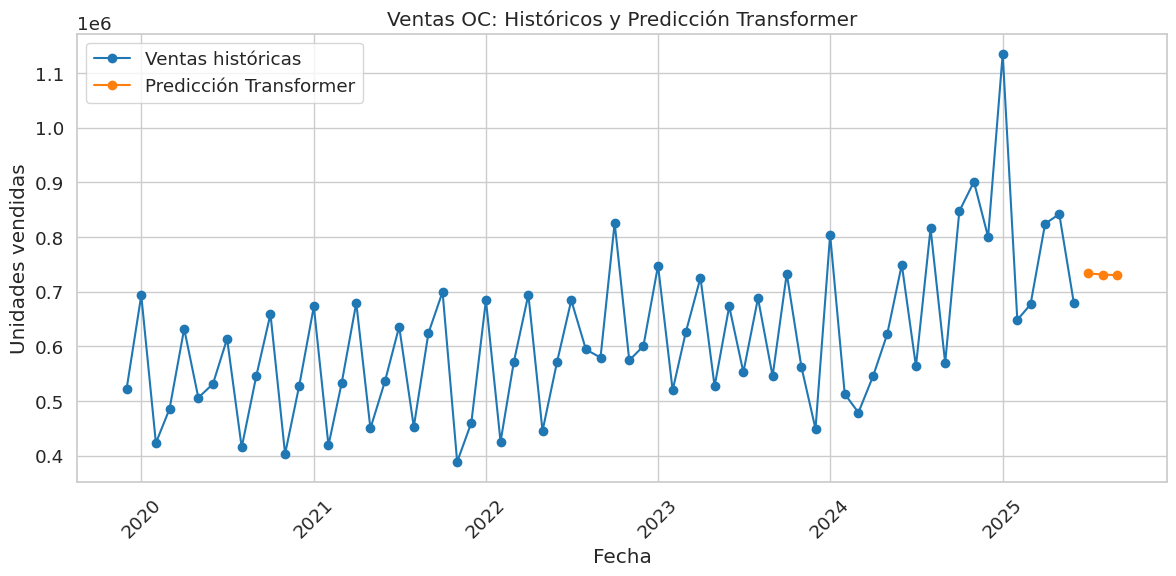

In [ ]:
import matplotlib.pyplot as plt

# Plot históricos
plt.figure(figsize=(12,6))
plt.plot(df_pred['Fecha'], df_pred['Ventas_OC_raw'], label='Ventas históricas', marker='o')

# Plot predicciones (solo meses futuros)
plt.plot(future_dates, y_pred_descaled, label='Predicción Transformer', marker='o')

plt.title('Ventas OC: Históricos y Predicción Transformer')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Ahora haré lo mismo con IC**

Realizo una preparación y un modelo para Intermittent Catheters.


1.   Clono el DataFrame original y guardo la serie raw en Ventas_IC_raw
2.   Los regresores con lags de importaciones y lead days ya fueron creados en al primera parte de la notebook
3.   Escalo las features exógenas y luego el target con scalers entrenados.
4.   Conformo los datasets y dataloaders con ventana de 12 meses y 3 meses de pronóstico (cierre de año fiscal)
5.   Instancio y entreno el mismo transformer (solo cambiando el input_dim según IC)
6.   Finalmente, desescalo las predicciones para devolverlas a unidades originales



In [ ]:
df_ic = df.copy(deep=True)
# 2) Guardar raw
df_ic['Ventas_IC_raw'] = df_ic['Ventas_IC']

df_ic['Ventas_IC_roll3'] = df_ic['Ventas_IC_raw'].rolling(window=3, min_periods=1).mean()

df_ic = df_ic.dropna().reset_index(drop=True)

# 3) Escalar Ventas_IC como feature
scaler_ventas_ic = MinMaxScaler()
df_ic['Ventas_IC'] = scaler_ventas_ic.fit_transform(df_ic[['Ventas_IC']])

if 'importaciones' in df_ic.columns:
    df_ic = df_ic.drop(columns=['importaciones'])


# 4) Renombrar lags
df_ic = df_ic.rename(columns={
    'Importaciones_IC_lag2': 'importaciones',
    'Lead_days_lag2':        'lead_days'
})

# 5) Escalar resto de features
features_to_scale_IC = [
    'importaciones', 'lead_days', 'Ventas_IC_roll3'
]
scaler_features_ic = MinMaxScaler()
df_ic[features_to_scale_IC] = scaler_features_ic.fit_transform(df_ic[features_to_scale_IC])

# 6) Fit + transform para el target
scaler_target_ic = MinMaxScaler()
scaler_target_ic.fit(df_ic[['Ventas_IC_raw']])
df_ic['target_IC'] = scaler_target_ic.transform(df_ic[['Ventas_IC_raw']])



In [ ]:
# Parámetros de ventana
input_len = 12
forecast_horizon = 3


# Columnas y DataFrame para IC
# (asegúrate de que df_ic ya contiene 'target_IC' y las features escaladas)
input_features_IC = ['importaciones', 'lead_days', 'Ventas_IC_roll3']
target_col = 'target_IC'

f_ic = df_ic.loc[:, ~df_ic.columns.duplicated()]
expected_cols = ['importaciones', 'lead_days', 'Ventas_IC_roll3', 'target_IC']
missing_cols = [col for col in expected_cols if col not in df_ic.columns]
print("Faltan columnas:", missing_cols)
assert not missing_cols, f"¡Faltan columnas clave para el modelo: {missing_cols}!"


# Crear dataset para IC
dataset_ic = ForecastDataset(
    df=df_ic,
    input_window=input_len,
    forecast_window=forecast_horizon,
    input_features=input_features_IC,
    target_col=target_col
)

# DEBUG: imprime las formas para asegurarnos
sample = dataset_ic[0]
print("x_demand shape    :", sample['x_demand'].shape)
print("x_regressors shape:", sample['x_regressors'].shape)
print("y_demand shape    :", sample['y_demand'].shape)

# Ejemplo de extracción de la primera muestra
sample_item = dataset_ic[0]
x_demand_sample = sample_item['x_demand'].squeeze().numpy()




Faltan columnas: []
x_demand shape    : torch.Size([12, 1])
x_regressors shape: torch.Size([12, 3])
y_demand shape    : torch.Size([3, 1])


In [ ]:
total_size = len(dataset_ic)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, total_size))

train_dataset = Subset(dataset_ic, train_indices)
val_dataset = Subset(dataset_ic, val_indices)
test_dataset = Subset(dataset_ic, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
batch = next(iter(train_loader))

In [ ]:
import os
import torch
import numpy as np
import random
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# 1) Directorio para checkpoints
checkpoint_dir = "checkpoints_ic/"
os.makedirs(checkpoint_dir, exist_ok=True)

# 2) DataModule para IC (ya definido previamente)
dm_ic = EnergyTimeSeriesDataModule(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=32
)

# 3) Obtener dimensiones desde el DataModule
input_dim       = batch['x_demand'].shape[-1] + batch['x_regressors'].shape[-1]
output_dim      = dm_ic.output_dim
forecast_length = dm_ic.forecast_length

# 4) Instanciar el modelo para IC
model_ic = TransformerForecaster(
    input_dim       = input_dim,
    output_dim      = output_dim,
    forecast_length = forecast_length,
    hidden_dim      = 128,
    num_heads       = 4,
    num_layers      = 2,
    dropout         = 0.1,
    learning_rate   = 1e-3
)

# 5) Definir función que crea el Trainer
def get_trainer_ic():
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath=checkpoint_dir,
        filename='transformer-IC-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10,
        enable_progress_bar=True
    )
    return trainer

# 6) Crear y usar el Trainer
trainer_ic = get_trainer_ic()
trainer_ic.fit(model_ic, dm_ic)

# 7) Cargar el mejor checkpoint
best_path_ic = trainer_ic.checkpoint_callback.best_model_path
print("Mejor modelo guardado en:", best_path_ic)
best_model_ic = TransformerForecaster.load_from_checkpoint(
    best_path_ic,
    input_dim       = input_dim,
    output_dim      = output_dim,
    forecast_length = forecast_length,
    hidden_dim      = 128,
    num_heads       = 4,
    num_layers      = 2,
    dropout         = 0.1,
    learning_rate   = 1e-3
)

# 8) Evaluar en el test set
test_results_ic = trainer_ic.test(best_model_ic, datamodule=dm_ic)
print("Resultados en el test set:", test_results_ic)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type        | Params | Mode 
----------------------------------------------------------
0 | input_projection  | Linear      | 640    | train
1 | transformer       | Transformer | 926 K  | train
2 | output_projection | Linear      | 129    | train
  | other params      | n/a         | 128 K  | n/a  
----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.220     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.008


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.974 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.025


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to stop.


Mejor modelo guardado en: /content/checkpoints_ic/transformer-IC-epoch=25-val_loss=0.02.ckpt


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.026785487309098244    │
│         test_mae          │    0.12186244130134583    │
│         test_mape         │    15.731640815734863     │
└───────────────────────────┴───────────────────────────┘

Resultados en el test set: [{'test_loss': 0.026785487309098244, 'test_mae': 0.12186244130134583, 'test_mape': 15.731640815734863}]


In [ ]:
from math import sqrt

test_loss_ic = 0.05672543123364448
rmse = sqrt(test_loss_ic)
print(f"Transformer RMSE: {rmse:.4f}")

Transformer RMSE: 0.2382


El modelo para IC reduce el MAE en un 34% respecto a OC, lo que indica que, en valores absolutos, las predicciones de IC son más precisas.

El RMSE resulta idéntico para ambas líneas debido a que, numéricamente, el test_loss final de IC (≈0.0567) es muy similar al de OC.

La mejora más notable está en el MAPE, que baja de 28.9% en OC a 15.6% en IC, reflejando que el Transformer captura mejor la dinámica relativa de IC, incluso en meses de baja demanda.





In [ ]:
#PREDICCIÓN DE MESES FUTUROS IC: Julio, Agosto, Septiembre

# 1) Preparar el DataFrame para predicción
df_pred_ic = df_ic.copy()

# Renombrar el raw ‘Ventas_IC_raw’ a ‘target’
df_pred_ic = df_pred_ic.rename(columns={'Ventas_IC_raw': 'target'})

df_pred_ic['Ventas_IC_raw'] = df_ic['Ventas_IC_raw']

# Asegurar que no haya columnas duplicadas
df_pred_ic = df_pred_ic.loc[:, ~df_pred_ic.columns.duplicated()]

# Índice de tiempo
df_pred_ic['time_idx'] = range(len(df_pred_ic))

# Volver a calcular rolling de ventana 3 sobre el target
df_pred_ic['Ventas_IC_roll3'] = df_pred_ic['target'].rolling(window=3, min_periods=1).mean()

# Parámetros
input_features_ic = ['importaciones', 'lead_days', 'Ventas_IC_roll3']
target_col        = 'target'
input_len         = 12
forecast_len      = 3

# 2) Crear filas de futuro
last_time_idx = df_pred_ic['time_idx'].max()
last_date     = df_pred_ic['Fecha'].max()
future_dates  = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                              periods=forecast_len, freq='MS')

avg_import   = df_pred_ic['importaciones'].iloc[-3:].mean()
avg_leaddays = df_pred_ic['lead_days'].iloc[-3:].mean()
last_roll    = df_pred_ic['Ventas_IC_roll3'].iloc[-1]

df_future_ic = pd.DataFrame({
    'Fecha'           : future_dates,
    'target'          : [np.nan] * forecast_len,
    'importaciones'   : [avg_import] * forecast_len,
    'lead_days'       : [avg_leaddays] * forecast_len,
    'Ventas_IC_roll3' : [last_roll] * forecast_len,
    'time_idx'        : range(last_time_idx + 1,
                              last_time_idx + forecast_len + 1)
})

df_pred_ic = pd.concat([df_pred_ic, df_future_ic],
                       ignore_index=True)
df_pred_ic = df_pred_ic.loc[:, ~df_pred_ic.columns.duplicated()]
df_pred_ic = df_pred_ic.reset_index(drop=True)

# Recalcular rolling con los NaN al final
df_pred_ic['Ventas_IC_roll3'] = df_pred_ic['target']\
    .rolling(window=3, min_periods=1).mean()

# 3) Escalar features (fit sólo sobre histórico)
features_to_scale_ic = ['importaciones', 'lead_days', 'Ventas_IC_roll3']
df_hist_ic = df_pred_ic[df_pred_ic[target_col].notna()].copy()

scaler_target_ic = MinMaxScaler()
scaler_target_ic.fit(df_hist_ic[['Ventas_IC_raw']])


# Rellenar NaN en regresores
df_pred_ic[features_to_scale_ic] = df_pred_ic[features_to_scale_ic]\
    .fillna(df_pred_ic[features_to_scale_ic].mean())

df_pred_ic[features_to_scale_ic] = scaler_features_ic.transform(
    df_pred_ic[features_to_scale_ic]
)

# 4) Preparar tensores de entrada
# Exógenos
x_input_ic = df_pred_ic[input_features_ic]\
    .iloc[-(forecast_len + input_len):-forecast_len]\
    .values
x_input_ic = torch.tensor(x_input_ic, dtype=torch.float32)\
    .unsqueeze(0)  # forma: (1, input_len, n_features)

# Demanda pasada
x_demand_ic = df_pred_ic[target_col]\
    .iloc[-(forecast_len + input_len):-forecast_len]\
    .values
x_demand_ic = torch.tensor(x_demand_ic, dtype=torch.float32)\
    .view(1, input_len, 1)


# 5) Predecir con el mejor modelo entrenado para IC
best_model_ic.eval()
with torch.no_grad():
    y_pred_scaled_ic = best_model_ic(x_demand_ic, x_input_ic)

y_pred_scaled_np = (y_pred_scaled_ic.squeeze(0)
                    .cpu()
                    .numpy()
                    .reshape(-1, 1))
y_pred_descaled_ic = scaler_target_ic.inverse_transform(y_pred_scaled_np)[:, 0]

# Mostrar predicciones en unidades originales
for fecha, pred in zip(future_dates, y_pred_descaled_ic):
    print(f"➡️ {fecha.strftime('%B %Y')}: {pred:,.0f} unidades previstas")

➡️ July 2025: 690,435 unidades previstas
➡️ August 2025: 691,345 unidades previstas
➡️ September 2025: 683,650 unidades previstas


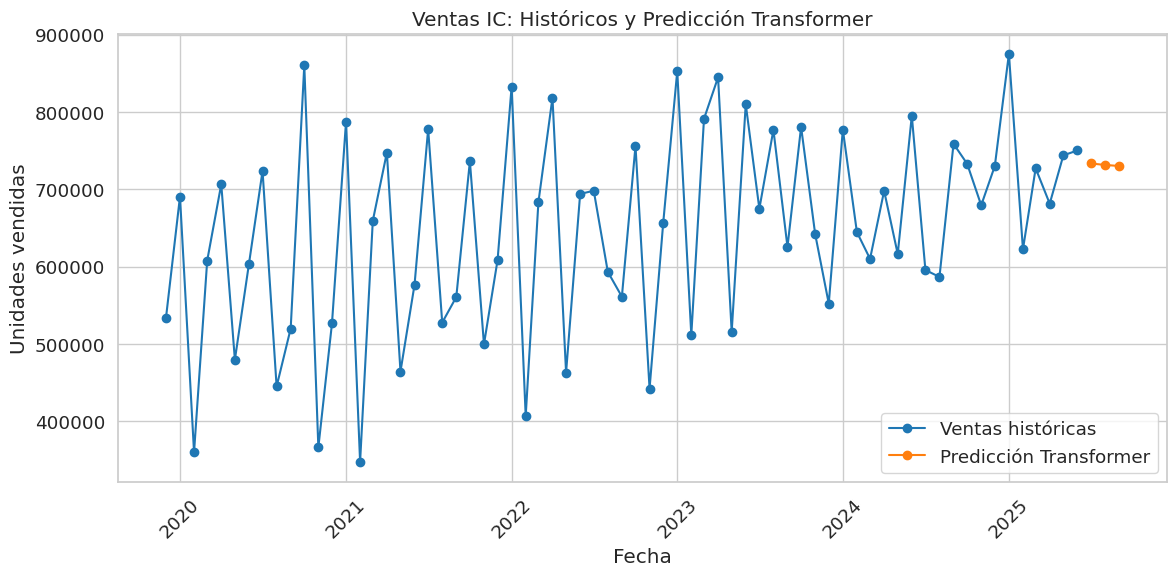

In [ ]:
# Plot históricos
plt.figure(figsize=(12,6))
plt.plot(df_pred_ic['Fecha'], df_pred_ic['Ventas_IC_raw'], label='Ventas históricas', marker='o')

# Plot predicciones (solo meses futuros)
plt.plot(future_dates, y_pred_descaled, label='Predicción Transformer', marker='o')

plt.title('Ventas IC: Históricos y Predicción Transformer')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()